In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hist
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from utils import data_prep

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# Load data, converting columns types for convenience, labeling NAs
df = data_prep.load_and_prep_data("data/ncdatachallenge-2021-v1.csv")

32.0


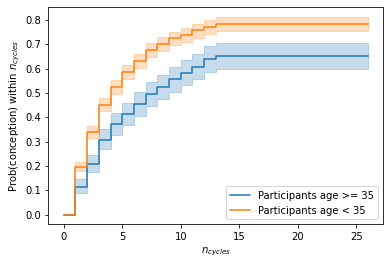

In [107]:
print(df["age"].median())
# Use 35 as it's a common number in the literature
fig = data_prep.compare_km_cumulatives(df, "age", 35, 35)

0.5054151624548736


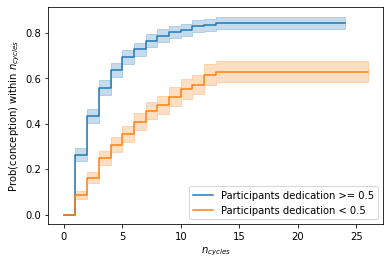

In [105]:
print(df["dedication"].median())
fig = data_prep.compare_km_cumulatives(df, "dedication", 0.5, 0.5)

29.0


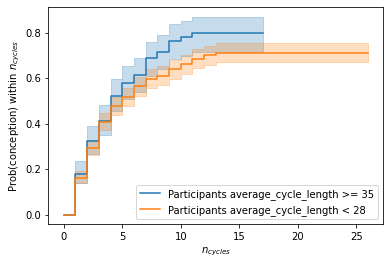

In [106]:
print(df["average_cycle_length"].median())
fig = data_prep.compare_km_cumulatives(df, "average_cycle_length", 28, 35)

2.542726629381084


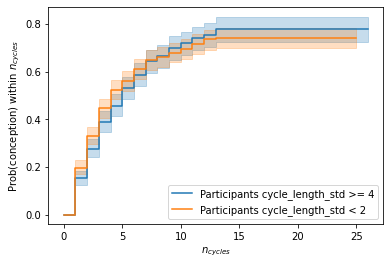

In [103]:
print(df["cycle_length_std"].median())
fig = data_prep.compare_km_cumulatives(df, "cycle_length_std", 2, 4)

0.0802139037433155


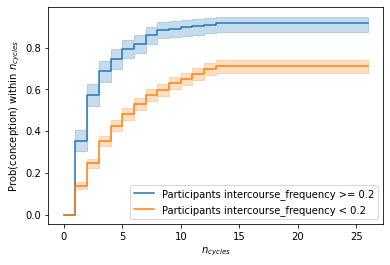

In [104]:
print(df["intercourse_frequency"].median())
fig = data_prep.compare_km_cumulatives(df, "intercourse_frequency", 0.2, 0.2)

1.0


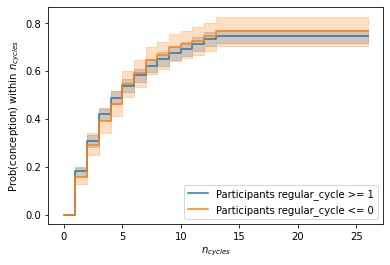

In [46]:
print(df["regular_cycle"].median())
fig = data_prep.compare_km_cumulatives(df, "regular_cycle", 0, 1)

Clearly age, dedication, and intercourse frequency have highly signficant impacts on TTP. Cycle length hints at some impact, but it is not highly signficant on its own. cycle_length_std and regular cycle (which are highly correlated) do not show a strong statistically signficant impact

In order to obtain the impact of variables while considering their interplay with other variables, we can attempt to perform a regression on the pregnancy outcome. This isn't expected to give a very performant model, because many biological factors that are expected to impact pregancy outcomes are not  recorded, however, it can be a useful estimate of which observables in the data set do give meaningful information about the pregnancy outcome

In [47]:
# Fix some missing variables (nans for cycle_length_std) and set impossible values.
# it's perhaps dangerous for a true prediction but it's ok for the purpose of variable estimation
df_ana = data_prep.prep_data_for_analysis(df)

In [49]:
# Let's assume these aren't miraculous conceptions
df_ana[(df_ana["intercourse_frequency"] == 0.) & df_ana["pregnant"]]

,bmi,age,country,been_pregnant_before,education,sleeping_pattern,n_cycles_trying,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency,pregnant
20,18.591130,34,Other,"No, never",Unreported,Unreported,1,0.416667,27.266667,2.374467,True,0.0,True
32,23.183391,33,Other,"No, never",PhD,Wake same every workday,3,0.827160,27.400000,1.919821,True,0.0,True
35,28.136342,38,GB,"No, never",Unreported,Several times during the night,9,0.797297,24.666667,1.239448,True,0.0,True
38,22.132210,34,GB,Yes 3 times or more,Unreported,Unreported,1,0.692308,26.666667,0.577350,True,0.0,True
63,24.538965,32,GB,"No, never",University,Several times during the night,2,0.096774,29.750000,3.095696,True,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,31.615526,38,Other,"No, never",University,Several times during the night,12,0.448753,30.125000,3.947573,True,0.0,True
1931,24.964946,31,SE,"No, never",University,Wake same every day,1,1.000000,25.571429,1.902379,True,0.0,True
1953,22.145329,29,SE,Yes 3 times or more,Unreported,Unreported,3,0.650602,27.000000,1.154701,True,0.0,True
1988,18.125235,30,Other,"No, never",PhD,Wake same every day,2,0.882353,34.545455,7.047888,False,0.0,True


In [62]:
# One hot encode categorical variables. Take 70% of the data for training
df_train = df_ana.drop(["n_cycles_trying"], axis=1)[:int(0.7*len(df_ana))]
df_onehot = pd.get_dummies(df_train.drop("pregnant", axis=1))
df_onehot

,bmi,age,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency,country_SE,country_US,country_GB,...,education_PhD,education_Trade/technical/vocational training,education_University,education_Unreported,sleeping_pattern_Late and snoozer,sleeping_pattern_Several times during the night,sleeping_pattern_Shift worker,sleeping_pattern_Unreported,sleeping_pattern_Wake same every day,sleeping_pattern_Wake same every workday
0,22.942130,31,0.640000,25.588235,2.526332,True,0.200000,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,19.886054,34,0.009569,30.875000,3.522884,True,0.052632,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,29.323049,41,0.298246,27.666667,2.503331,True,0.149123,1,0,0,...,0,0,1,0,0,1,0,0,0,0
3,24.386526,27,0.895833,24.250000,3.453776,True,0.145833,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,29.299971,29,0.666667,25.466667,0.990430,True,0.254902,1,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,22.321429,23,0.000000,37.000000,6.595453,False,0.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1392,21.759436,36,0.666667,29.411765,2.739955,True,0.250000,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1393,28.959000,35,0.837573,27.259259,1.403090,True,0.015656,1,0,0,...,0,0,1,0,1,0,0,0,0,0
1394,22.322962,28,0.448276,30.500000,2.880972,True,0.068966,1,0,0,...,0,0,1,0,0,0,0,0,0,1


In [63]:
model = sm.Logit(df_train["pregnant"], df_onehot.astype('float'))
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.561975
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               pregnant   No. Observations:                 1396
Model:                          Logit   Df Residuals:                     1370
Method:                           MLE   Df Model:                           25
Date:                Tue, 14 Nov 2023   Pseudo R-squ.:                  0.1709
Time:                        23:21:34   Log-Likelihood:                -784.52
converged:                       True   LL-Null:                       -946.20
Covariance Type:            nonrobust   LLR p-value:                 1.194e-53
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
bmi                                                -0.0035      0.012     -0.281      0.779      -0.028       0.021
age                                                -0.0414      0.017     -2.455      0.014      -0.074      -0.008
dedication                                          2.4097      0.221     10.910      0.000       1.977       2.843
average_cycle_length                                0.0290      0.017      1.751      0.080      -0.003       0.061
cycle_length_std                                   -0.0401      0.017     -2.341      0.019      -0.074      -0.007
regular_cycle                                      -0.0293      0.193     -0.152      0.879      -0.407       0.349
intercourse_frequency                               4.0102      0.748      5.359      0.000       2.544       5.477
country_SE                                         -0.1607   5.23e+06  -3.07e-08      1.000   -1.02e+07    1.02e+07
country_US                                         -0.3180   5.23e+06  -6.08e-08      1.000   -1.02e+07    1.02e+07
country_GB                                          0.0027   5.23e+06   5.15e-10      1.000   -1.02e+07    1.02e+07
country_Unreported                                 -0.4251   5.23e+06  -8.13e-08      1.000   -1.02e+07    1.02e+07
country_Other                                      -0.1323   5.23e+06  -2.53e-08      1.000   -1.02e+07    1.02e+07
been_pregnant_before_No, never                     -0.1750        nan        nan        nan         nan         nan
been_pregnant_before_Unreported                    -0.0776        nan        nan        nan         nan         nan
been_pregnant_before_Yes 3 times or more           -0.7739        nan        nan        nan         nan         nan
been_pregnant_before_Yes, once                     -0.1581        nan        nan        nan         nan         nan
been_pregnant_before_Yes, twice                     0.1512        nan        nan        nan         nan         nan
education_Elementary school                        -0.3911   6.94e+06  -5.64e-08      1.000   -1.36e+07    1.36e+07
education_High school                              -0.2363   6.94e+06  -3.41e-08      1.000   -1.36e+07    1.36e+07
education_PhD                                      -0.1704   6.94e+06  -2.46e-08      1.000   -1.36e+07    1.36e+07
education_Trade/technical/vocational training      -0.1201   6.94e+06  -1.73e-08      1.000   -1.36e+07    1.36e+07
education_University                                0.0113   6.94e+06   1.63e-09      1.000   -1.36e+07    1.36e+07
education_Unreported                               -0.1268   6.94e+06  -1.83e-08      1.000   -1.36e+07    1.36e+07
sleeping_pattern_Late and snoozer                  -0.3755   5.43e+06  -6.91e-08      1.000   -1.06e+07    1.06e+07
sleeping_pattern_Several times during the night    -0.3099   5.43e+06  -5.71e-08      1.000   -1.06e+07    1.

Fit the model with everything in it. We can use the statistical significance of the fitted parameters to estimate the impact of the given variables on the outcome. The categorical variables do not have a measurable impact in this model. Only bmi, age, dedication, average_cycle_legnth, cycle_lenth_std, intercourse_frenquency, and regular_cycle show at all signficant results, with bmi and regular_cycle not really being significant.

Now rebuild the model, keeping only the significant features from before. It is useful to renormalize the features to have a better handle of the relative importance of the fitted paramters.

In [89]:
from sklearn.preprocessing import StandardScaler

df_prune_min = df_ana.drop(["education", "sleeping_pattern", "country", "been_pregnant_before", ], axis=1)

cols_to_norm = ['age','bmi', "average_cycle_length", "dedication", "intercourse_frequency"]
df_prune_min[cols_to_norm] = StandardScaler().fit_transform(df_prune_min[cols_to_norm])

df_prune_min_onehot = pd.get_dummies(df_prune_min.drop(["n_cycles_trying", "pregnant"], axis=1))
df_prune_min_onehot_train = df_prune_min_onehot.iloc[:int(len(df_prune_min_onehot)*0.7),:]
df_prune_min_onehot_test = df_prune_min_onehot.iloc[int(len(df_prune_min_onehot)*0.7):,:]
df_prune_min_train = df_prune_min.iloc[:int(len(df_prune_min_onehot)*0.7),:]
df_prune_min_test = df_prune_min.iloc[int(len(df_prune_min_onehot)*0.7):,:]
result_prune = sm.Logit(df_prune_min_train["pregnant"], df_prune_min_onehot_train.astype('float')).fit()
result_prune.summary()

Optimization terminated successfully.
         Current function value: 0.573384
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               pregnant   No. Observations:                 1396
Model:                          Logit   Df Residuals:                     1389
Method:                           MLE   Df Model:                            6
Date:                Tue, 14 Nov 2023   Pseudo R-squ.:                  0.1540
Time:                        23:36:58   Log-Likelihood:                -800.44
converged:                       True   LL-Null:                       -946.20
Covariance Type:            nonrobust   LLR p-value:                 5.389e-60
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
bmi                      -0.0367      0.060     -0.615      0.539      -0.154       0.080
age                      -0.1559      0.062     -2.518      0.012      -0.277      -0.035
dedication                0.7745      0.069     11.145      0.000       0.638       0.911
average_cycle_length      0.1427      0.109      1.304      0.192      -0.072       0.357
cycle_length_std         -0.0110      0.012     -0.944      0.345      -0.034       0.012
regular_cycle             0.5248      0.087      6.061      0.000       0.355       0.695
intercourse_frequency     0.3966      0.076      5.215      0.000       0.248       0.546
=========================================================================================
"""

In [90]:
df_prune_min_onehot_train = df_prune_min_onehot_train.drop("regular_cycle", axis=1)
df_prune_min_onehot_test = df_prune_min_onehot_test.drop("regular_cycle", axis=1)
result_prune_full = sm.Logit(df_prune_min_train["pregnant"], df_prune_min_onehot_train.astype('float')).fit()
result_prune_full.summary()

Optimization terminated successfully.
         Current function value: 0.586983
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               pregnant   No. Observations:                 1396
Model:                          Logit   Df Residuals:                     1390
Method:                           MLE   Df Model:                            5
Date:                Tue, 14 Nov 2023   Pseudo R-squ.:                  0.1340
Time:                        23:37:00   Log-Likelihood:                -819.43
converged:                       True   LL-Null:                       -946.20
Covariance Type:            nonrobust   LLR p-value:                 9.543e-53
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
bmi                      -0.0307      0.060     -0.515      0.607      -0.148       0.086
age                      -0.1606      0.062     -2.610      0.009      -0.281      -0.040
dedication                0.7719      0.069     11.255      0.000       0.637       0.906
average_cycle_length     -0.2298      0.089     -2.589      0.010      -0.404      -0.056
cycle_length_std          0.0283      0.009      3.013      0.003       0.010       0.047
intercourse_frequency     0.3684      0.073      5.061      0.000       0.226       0.511
=========================================================================================
"""

With only relevant variables included, we see that age does have a measurable effect. Other studies report increased TTP for those with particularly high or low BMI, but this is not quantifiable with this data set. cycle_length and its std deviation as well as intercourse frequency have measureable effects. Because regular_cycle is highly correlated with average_cycle_length and cycle_length_std, its inclusion impacts their signficance. Further investigation would be needed to atribute which model is more performant, but without further investigation, I take the latter with the two continuous variables as nominal, under the assumption that they contain more granular information

In [91]:
res = result_prune_full.predict(df_prune_min_onehot_test.astype('float')) > 0.5

In [92]:
from sklearn.metrics import (confusion_matrix,  
                           accuracy_score, ConfusionMatrixDisplay) 
  
# confusion matrix 
cm = confusion_matrix(df_prune_min_test["pregnant"].values, res)  

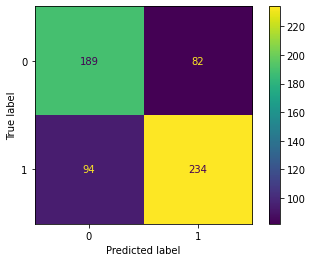

In [93]:
ConfusionMatrixDisplay(cm).plot()

In [94]:
accuracy_score(df_prune_min_test["pregnant"].values, res)  

0.7061769616026711

The accuracy of 70% is not particularly high, which is perhaps expected. In any case, the model does have some predicting value, which justifies its use in quantifying the variable importance

In [99]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=0)
forest.fit(df_onehot, df_train["pregnant"])

RandomForestClassifier(random_state=0)

Another model that can independently estimate feature importance is a boosted decision tree. The scikit-learn package can performance feature importance estimating the decrease in a model score when a single feature value is randomly shuffled. It is reassuring that the variable improtance from this technique is highly consistent with those from the logistic regression. With more time for investigation, the performance of each model could be evaluated, as well as the impact of the inclusion of lower-ranking features on the model performance.

Text(0, 0.5, 'Mean decrease in impurity')

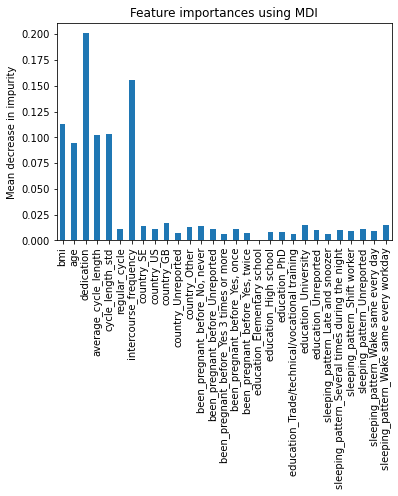

In [100]:
importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=df_onehot.columns)
#std = np.std([t.feature_importances_ for t in forest.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

Lastly, as the question asks specifically about the TTP, a full regression of the survival probability would be interesting. Whereas the regression models (logistic and RF) only seek to estimate if the participant will achieve pregnancy, a survival model also seeks to estimate the pregnancy time. A very quick look at this shows high consistent results for the variable signficance as for the simple logistic regression.

In [102]:
from lifelines import CoxPHFitter

df_onehot_min = pd.get_dummies(df_prune_min)
# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df_onehot_min, 'n_cycles_trying', event_col='pregnant')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1995 total observations, 847 right-censored observations>
             duration col = 'n_cycles_trying'
                event col = 'pregnant'
      baseline estimation = breslow
   number of observations = 1995
number of events observed = 1148
   partial log-likelihood = -7752.05
         time fit was run = 2023-11-14 22:50:37 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
bmi                    -0.00       1.00       0.03            -0.06             0.06                 0.94                 1.06
age                    -0.13       0.87       0.03            -0.19            -0.07                 0.82                 0.93
dedication              0.43       1.53       0.04             0.36             0.50                 1.43                 1.65
average_cycle_length    0.20       1.22       0.06             0.08             0.32                 1.08                 1.38
cycle_length_std       -0.03       0.97       0.01            -0.05            -0.01                 0.95                 0.99
regular_cycle           0.10       1.10       0.10            -0.10             0.29                 0.91                 1.33
intercourse_frequency   0.27       1.31       0.03             0.20             0.33                 1.23                 1.39

                        cmp to     z      p   -log2(p)
covariate                                             
bmi                       0.00 -0.01   0.99       0.01
age                       0.00 -4.42 <0.005      16.60
dedication                0.00 11.57 <0.005     100.37
average_cycle_length      0.00  3.25 <0.005       9.78
cycle_length_std          0.00 -2.71   0.01       7.22
regular_cycle             0.00  0.98   0.33       1.62
intercourse_frequency     0.00  8.46 <0.005      55.11
---
Concordance = 0.70
Partial AIC = 15518.10
log-likelihood ratio test = 405.14 on 7 df
-log2(p) of ll-ratio test = 274.80